# ADVANCED LANE LINE DETECTOR
To detect lane lines, this project follows a pipeline as described below:
1. Compute the camera <b>calibration matrix</b> and <b>distortion coefficients</b>
2. Generate <b>perspective warp image</b> ('birds-eye view') to analyze the lanelines
3. Detect laneline regions and fit polynomial curves
4. Highlight laneline area and calculate curvatures
---

In [1]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

### Calculating calibration matrix and distortion coefficients using chessboard images


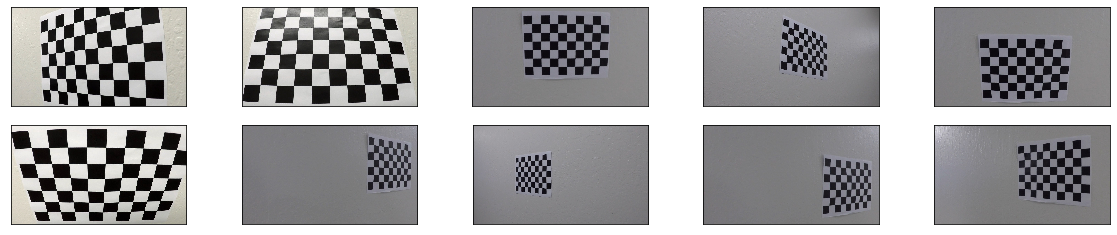

In [2]:
# Read some chessboard images that we use for calibration
chessboard_images = os.listdir("./camera_cal/")

fig = plt.figure(figsize=(20, 4))
for idx in np.arange(10):
    image = mpimg.imread(f'./camera_cal/{chessboard_images[idx]}')
    ax = fig.add_subplot(2, 10/2, idx+1, xticks=[], yticks=[])
    plt.imshow(image)

In [3]:
# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# All images share the same object point set
objp = np.zeros((6*9, 3), dtype=np.float32)
objp[:, :2] = np.mgrid[:9, :6].T.reshape(-1, 2)

# Generate image points & object points for each chessboard image
for fname in chessboard_images:
    img = mpimg.imread(f'./camera_cal/{fname}')
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

    # Find corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
    
ret, cam_matrix, distortion_coefs, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1], None, None)

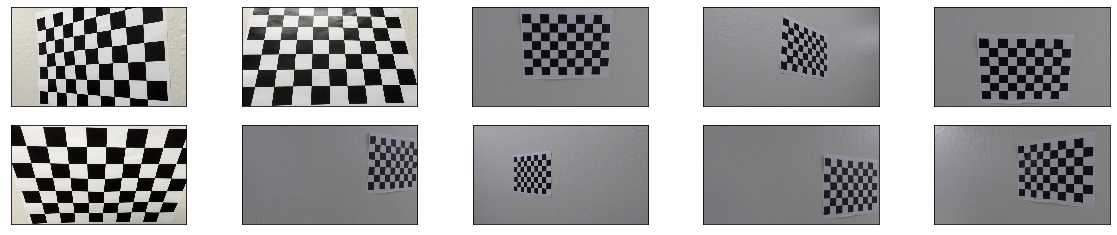

In [4]:
# Undistort some chessboard images using camera matrix and distortion coeficients
chessboard_images = os.listdir("./camera_cal/")

fig = plt.figure(figsize=(20, 4))
for idx in np.arange(10):
    image = mpimg.imread(f'./camera_cal/{chessboard_images[idx]}')
    undist = cv2.undistort(image, cam_matrix, distortion_coefs, None, cam_matrix)
    ax = fig.add_subplot(2, 10/2, idx+1, xticks=[], yticks=[])
    plt.imshow(undist)

### Generate 'birds-eye view' images of the lane lines (OvO)
---
**<i>1. Distortion Correction<i/>**

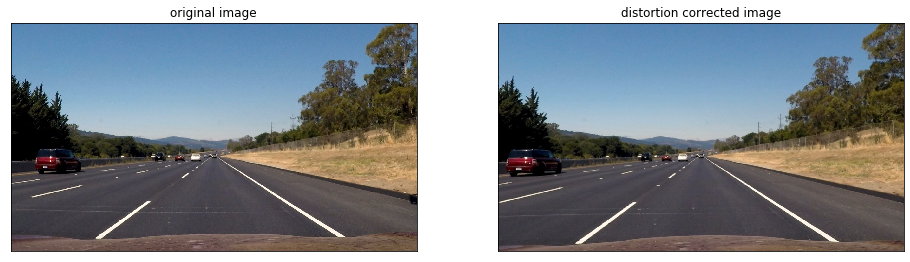

In [5]:
# Read a test image before and after distortion correction
img_name = 'test2.jpg'
img = mpimg.imread(f'./test_images/{img_name}')
undist_img = cv2.undistort(img, cam_matrix, distortion_coefs, None, cam_matrix)

fig = plt.figure(figsize=(16, 8))
fig.add_subplot(1, 2, 1, xticks=[], yticks=[]).set_title('original image')
plt.imshow(img)
fig.add_subplot(1, 2, 2, xticks=[], yticks=[]).set_title('distortion corrected image')
plt.imshow(undist_img)

**<i>2. Apply Gradient Thresholds & Color Thresholds<i/>**

In [6]:
def sobel_thresh(img, sobel_kernel=3, x_thresh=(0,255), y_thresh=(0,255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)    
    abs_sobel_x = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    abs_sobel_y = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))    
    scaled_sobel_x = np.uint8(255*abs_sobel_x/np.max(abs_sobel_x))
    scaled_sobel_y = np.uint8(255*abs_sobel_y/np.max(abs_sobel_y))
    binary_output = np.zeros_like(scaled_sobel_x)
    binary_output[(scaled_sobel_x >= x_thresh[0]) & (scaled_sobel_x <= x_thresh[1]) & \
                  (scaled_sobel_y >= y_thresh[0]) & (scaled_sobel_y <= y_thresh[1])] = 1
    return binary_output

# magnitude threshold
def mag_thresh(img, sobel_kernel=3, thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobelxy = np.sqrt(sobelx**2 + sobely**2)
    scaled_sobel = np.uint8(255 * abs_sobelxy / np.max(abs_sobelxy))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary_output

# direction threshold
def dir_thresh(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    abs_sobelx = np.absolute(sobel_x)
    abs_sobely = np.absolute(sobel_y)
    direction = np.arctan2(abs_sobely, abs_sobelx)
    binary_output = np.zeros_like(direction)
    binary_output[(direction >= thresh[0]) & (direction <= thresh[1])] = 1
    return binary_output

# hls color space threshold
def hls_thresh(img, h_thresh=(0, 255), l_thresh=(0, 255), s_thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    h, l, s = hls[:,:,0], hls[:,:,1], hls[:,:,2]
    binary_output = np.zeros(img.shape[:-1])
    binary_output[(h >= h_thresh[0]) & (h <= h_thresh[1]) & \
                  (l >= l_thresh[0]) & (l <= l_thresh[1]) & \
                  (s >= s_thresh[0]) & (s <= s_thresh[1])] = 1
    return binary_output

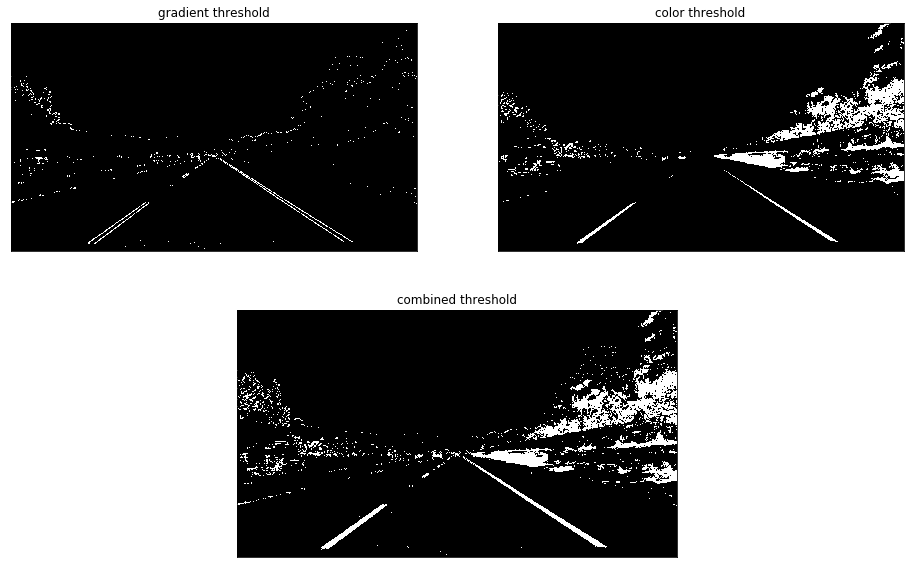

In [7]:
sobel_params = { 'sobel_kernel': 3,  'x_thresh': (50, 255), 'y_thresh': (50, 255)}
mag_params = { 'sobel_kernel': 3,  'thresh': (50, 255) }
dir_params = { 'sobel_kernel': 15, 'thresh': (0.7, 1.3) }
hls_params = { 's_thresh': (100, 255), 'h_thresh': (0, 65) }

gradient_thresh = (sobel_thresh(undist_img, **sobel_params)==1) | \
                  ((mag_thresh(undist_img, **mag_params)==1) & (dir_thresh(undist_img, **dir_params)==1)) 
color_thresh = hls_thresh(undist_img, **hls_params)
combined_thresh = (gradient_thresh==1) | (color_thresh==1)

fig = plt.figure(figsize=(16, 10))
fig.add_subplot(2, 2, 1, xticks=[], yticks=[]).set_title('gradient threshold')
plt.imshow(gradient_thresh, cmap='gray')
fig.add_subplot(2, 2, 2, xticks=[], yticks=[]).set_title('color threshold')
plt.imshow(color_thresh, cmap='gray')
fig.add_subplot(2, 1, 2, xticks=[], yticks=[]).set_title('combined threshold')
plt.imshow(combined_thresh, cmap='gray')

**<i>3. Apply Perspective Transformation<i/>**

In [8]:
# Define ROI region and its transformation
perspective_roi = np.array([[0.15, 1], [0.45, 0.64], [0.55, 0.64], [0.85, 1]], np.float32) 
topdown_roi = np.array([[0.25, 1], [0.25, 0.], [0.75, 0.], [0.75, 1]], np.float32)

# Generate source and destination points needed to calculate perspective transformation matrix
img_shape = combined_thresh.shape[::-1]
src = np.float32(perspective_roi * img_shape)
dst = np.float32(topdown_roi * img_shape)

# Perspective Transform Matrix and its inversed matrix
M = cv2.getPerspectiveTransform(src, dst)
M_inv = cv2.getPerspectiveTransform(dst, src)

Now we can visualize this transformation:

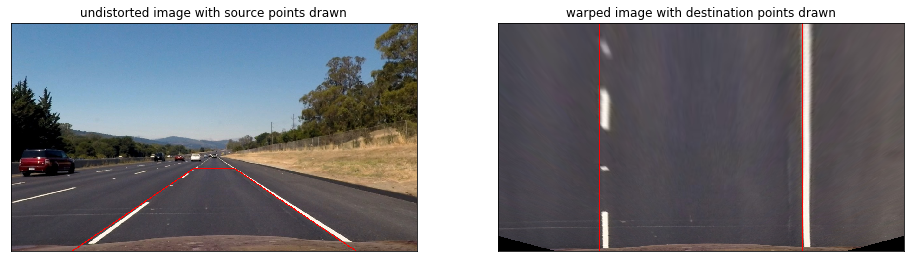

In [9]:
cloned_undist = np.copy(undist_img)
warped_undist = cv2.warpPerspective(cloned_undist, M, img_shape, flags=cv2.INTER_LINEAR)

cv2.polylines(cloned_undist, [np.int32(src)], True, color = (255, 0, 0), thickness = 2)
cv2.polylines(warped_undist, [np.int32(dst)], True, color = (255, 0, 0), thickness = 2)

fig = plt.figure(figsize=(16, 10))
fig.add_subplot(1, 2, 1, xticks=[], yticks=[]).set_title('undistorted image with source points drawn')
plt.imshow(cloned_undist)
fig.add_subplot(1, 2, 2, xticks=[], yticks=[]).set_title('warped image with destination points drawn')
plt.imshow(warped_undist)

Apply the same transformation for the <b>thresholded binary image</b> from previous step:

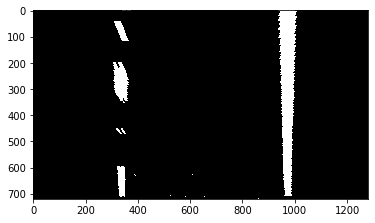

In [10]:
warped = cv2.warpPerspective(combined_thresh.astype(np.uint8)*255, M, img_shape, flags=cv2.INTER_LINEAR)
warped[warped > 0] = 1

# Display warped image
plt.figure()
plt.imshow(warped, cmap='gray')

### Detect Lanelines and Calculate Curvature

Text(0, 0.5, 'counts')

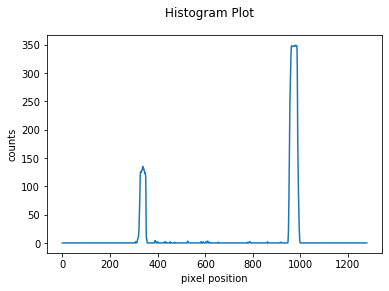

In [11]:
# Generate histogram based on warped image
histogram = np.sum(warped[warped.shape[0]//2:,:], axis=0)
fig = plt.figure()
fig.suptitle('Histogram Plot')
plt.plot(histogram)
plt.xlabel('pixel position')
plt.ylabel('counts')

In [12]:
midpoint = np.int(histogram.shape[0]//2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

In [13]:
# Give warped image 3 channels so we can draw windows and fitting curve in color
output_image = np.dstack((warped, warped, warped))*255 

In [14]:
# DEFINE HYPERPARAMETERS
nwindows = 9 # number of sliding windows
margin = 100 # margin of each window (+/- center)
minpix = 50  # minimum number of pixel to recenter window
window_height = np.int(warped.shape[0]//nwindows)

# Identify the x and y positions of all nonzero (i.e. activated) pixels in the image
nonzero = warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

# Current positions to be updated later for each window in nwindows
leftx_current = leftx_base
rightx_current = rightx_base

# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

In [15]:
img_height, img_width = warped.shape[0], warped.shape[1]

for window in range(nwindows):
    # Find boundaries of current windows (both left and right)
    y_low = warped.shape[0] - (window + 1) * window_height
    y_high = warped.shape[0] - window * window_height
    xleft_low = leftx_current - margin
    xleft_high = leftx_current + margin
    xright_low = rightx_current - margin
    xright_high = rightx_current + margin
 
    # Draw the windows
    cv2.rectangle(output_image,(xleft_low, y_low),
    (xleft_high, y_high),(0,255,0), 2) 
    cv2.rectangle(output_image,(xright_low, y_low),
    (xright_high, y_high),(0,255,0), 2)   
    
    # Find indices of pixels within the current window
    good_left_inds = ((nonzerox >= xleft_low) & (nonzerox < xleft_high) \
                        & (nonzeroy >= y_low) & (nonzeroy < y_high)).nonzero()[0]
    good_right_inds = ((nonzerox >= xright_low) & (nonzerox < xright_high) \
                        & (nonzeroy >= y_low) & (nonzeroy < y_high)).nonzero()[0]
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    
    # Recenter windows
    if (len(good_left_inds) >= minpix):
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if (len(good_right_inds) >= minpix):
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)
        
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]

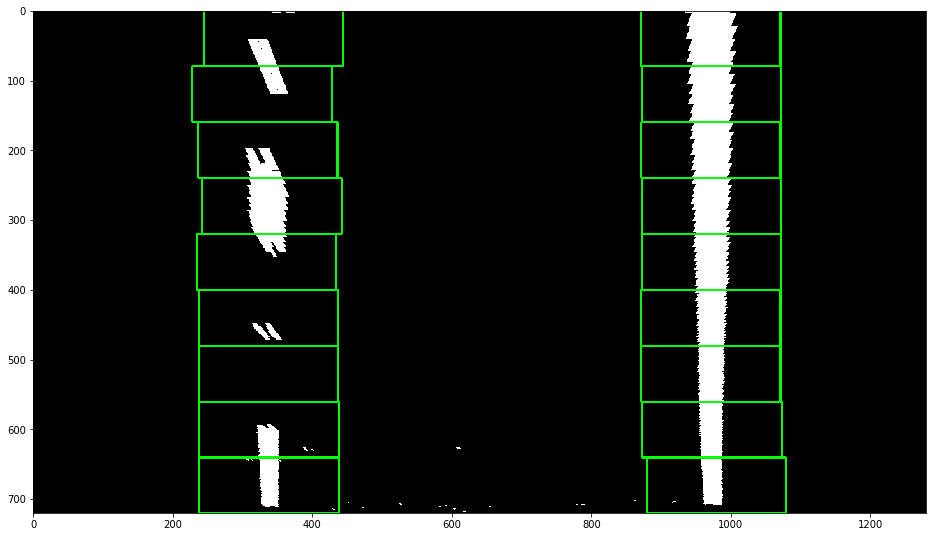

In [16]:
plt.figure(figsize=(16, 10))
plt.imshow(output_image)

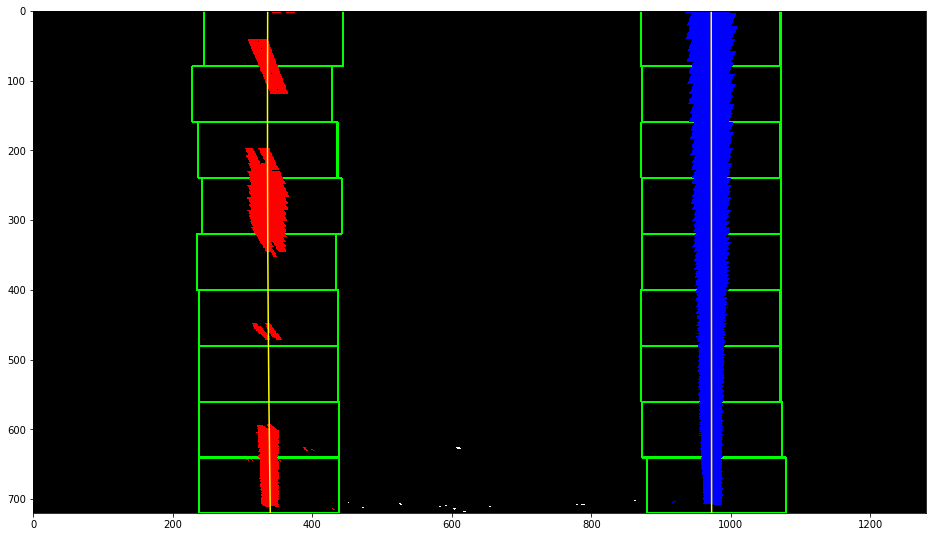

In [17]:
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

# Generate x and y values for plotting
ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

output_image[lefty, leftx] = [255, 0, 0]
output_image[righty, rightx] = [0, 0, 255]

# Plots the left and right polynomials on the lane lines
plt.figure(figsize=(16, 10))
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.imshow(output_image)

Instead of using sliding windows, we can also search for pixel near the polylines

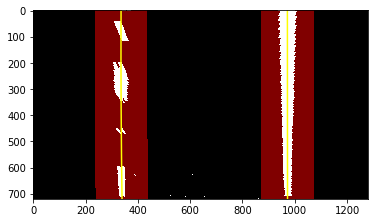

In [18]:
left_lane_inds = np.absolute(nonzerox - (left_fit[0] * nonzeroy**2 + left_fit[1] * nonzeroy + left_fit[2])) <= margin
right_lane_inds = np.absolute(nonzerox - (right_fit[0] * nonzeroy**2 + right_fit[1] * nonzeroy + right_fit[2])) <= margin
    
# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]

left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
ploty = np.linspace(0, img_height, img_width)
left_fitx = left_fit[0] * ploty**2 + left_fit[1] * ploty + left_fit[2] 
right_fitx = right_fit[0] * ploty**2 + right_fit[1] * ploty + right_fit[2]

# Reset output image
output_image = np.dstack((warped, warped, warped))*255 
window_image = np.zeros_like(output_image)
 
# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_image, np.int_([left_line_pts]), (255, 0, 0))
cv2.fillPoly(window_image, np.int_([right_line_pts]), (255, 0, 0))
result = cv2.addWeighted(output_image, 1, window_image, 0.5, 0)
    
# Plot the polynomial lines onto the image
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.imshow(result)

<b>Visualize current-lane region on undistorted color image:<b>

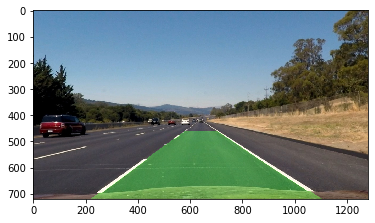

In [19]:
cloned_undist = np.copy(undist_img)
window_image = np.zeros_like(output_image)

downward_left_border = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
upward_right_border = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
current_lane_pts = np.hstack((downward_left_border, upward_right_border))
cv2.fillPoly(window_image, np.int_([current_lane_pts]), (0, 255, 0))

# Reverse previous perspective transformation
lane_region = cv2.warpPerspective(window_image, M_inv, img_shape, flags=cv2.INTER_LINEAR)
result = cv2.addWeighted(cloned_undist, 1, lane_region, 0.3, 0)
plt.imshow(result)

Calculate curvatures

In [22]:
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension    
  
y_eval = np.max(ploty)  
left_curverad = (1 + (2 * left_fit[0] * y_eval * ym_per_pix + left_fit[1])**2)**1.5 / np.absolute(2*left_fit[0])
right_curverad = (1 + (2 * right_fit[0] * y_eval * ym_per_pix + right_fit[1])**2)**1.5 / np.absolute(2*right_fit[0])

print(f'left curvature: {left_curverad} | right curvature: {right_curverad}')

left curvature: 40047.67182622128 | right curvature: 3145342.445938052


In [21]:
plt.imsave(f'output_images/{img_name}', result)